## 필요한 라이브러리를 로드합니다.

In [0]:
import os
import numpy as np
import pandas as pd

import sklearn
import tensorflow as tf
from tensorflow import keras

from google.colab import auth
from google.colab import drive

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### 데이터 로드를 위해 구글 드라이브를 연동합니다.

In [25]:
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 15분 전력사용량 데이터를 로드합니다. 

In [0]:
colab_dir ='/content/gdrive/My Drive/Colab Notebooks'
file_name = 'power_usage_201.csv'
data_file = os.path.join(colab_dir, "data", file_name)

df = pd.read_csv(data_file, header = 0, delimiter = ',', quoting = 3)
df.index = df['daq_time']

## 데이터를 확인합니다.

In [27]:
df.describe()

,power_usage
count,140256.000000
mean,242.393145
std,72.339054
min,0.000000
25%,189.859155
50%,249.014085
75%,288.450704
max,479.436620


In [28]:
df.head()

,daq_time,power_usage
daq_time,,
2011-01-01 00:15,2011-01-01 00:15,235.492958
2011-01-01 00:30,2011-01-01 00:30,239.436620
2011-01-01 00:45,2011-01-01 00:45,228.732394
2011-01-01 01:00,2011-01-01 01:00,230.422535
2011-01-01 01:15,2011-01-01 01:15,225.352113


In [29]:
df.tail()

,daq_time,power_usage
daq_time,,
2014-12-31 23:00,2014-12-31 23:00,149.295775
2014-12-31 23:15,2014-12-31 23:15,151.549296
2014-12-31 23:30,2014-12-31 23:30,147.042254
2014-12-31 23:45,2014-12-31 23:45,142.535211
2015-01-01 00:00,2015-01-01 00:00,143.098592


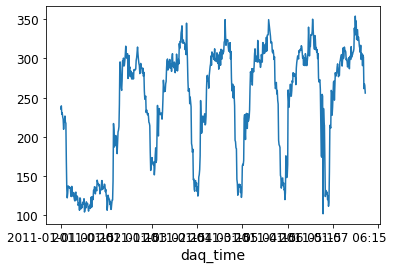

In [30]:
df_week = df.iloc[0:96*7]
df_week["power_usage"].plot()

In [0]:
series = df['power_usage'].values

### 데이터셋을 입력데이터와 타깃데이터로 분리하는 함수입니다.

In [0]:
def split_data_input_label(dataset, start_index, end_index, hist_data_size, target_size):
    data = []
    labels = []

    start_index = start_index + hist_data_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-hist_data_size, i)
        # Reshape data from (hist_data_size,) to (hist_data_size, 1)
        data.append(np.reshape(dataset[indices], (hist_data_size, 1)))
        labels.append([dataset[i+target_size]])
    return np.array(data), np.array(labels)

## 시계열 데이터를 정규화합니다.
 

* 상이한 스케일을 가진 값을 신경망에 주입하면 신경망 훈련이 어려우므로 데이터를 정규화합니다.
* 정규화 방법은 훈련데이터의 각 피처(feature)에서 평균을 빼고 각 피처의 표준편차로 나눕니다.
* 데이터 정규화를 통해 데이터의 평균은 0, 표준편차는 1인 데이터셋이 만들어집니다.
* 훈련 데이터 값만 이용하여 데이터를 정규화 합니다.


In [0]:
train_split = 70080 # 365일 * 2년 * 96개데이터
test_split = 105120 # 365일 * 3년 * 96개데이터

train_data_mean = series[:train_split].mean()
train_data_std = series[:train_split].std()
dataset = (series - train_data_mean)/train_data_std

## 훈련 데이터셋과 검증 데이터셋으로 데이터를 분할합니다.

In [0]:
n_steps = 20
future_target = 0

X_train, y_train = split_data_input_label(dataset, 0,train_split, 
                                          n_steps, 
                                          future_target)
X_valid, y_valid = split_data_input_label(dataset,train_split,test_split, 
                                          n_steps, 
                                          future_target)
X_test, _ = split_data_input_label(dataset, test_split, test_split+1000, 
                                   n_steps, 
                                   future_target)

## 입력데이터, 타깃데이터, 예측데이터를 그래프로 출력하는 함수입니다.

In [0]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, min(series) - abs(min(series)/10) , max(series) + abs(max(series)/10)])

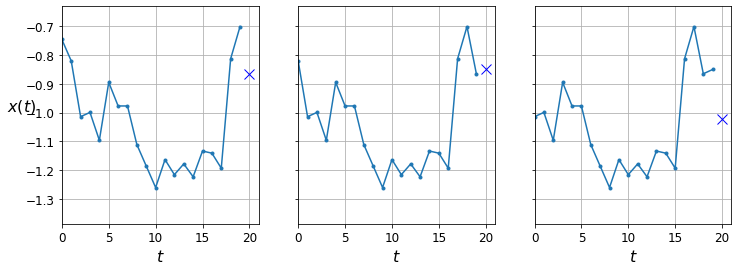

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

## 신경망 모델 구성 설정 

In [37]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam", metrics=["mean_squared_error", "mean_absolute_error"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
2190/2190 [==============================] - 30s 14ms/step - loss: 0.0580 - mean_squared_error: 0.0580 - mean_absolute_error: 0.1639 - val_loss: 0.0304 - val_mean_squared_error: 0.0304 - val_mean_absolute_error: 0.1211
Epoch 2/10
2190/2190 [==============================] - 29s 13ms/step - loss: 0.0337 - mean_squared_error: 0.0337 - mean_absolute_error: 0.1331 - val_loss: 0.0295 - val_mean_squared_error: 0.0295 - val_mean_absolute_error: 0.1231
Epoch 3/10
2190/2190 [==============================] - 29s 13ms/step - loss: 0.0329 - mean_squared_error: 0.0329 - mean_absolute_error: 0.1317 - val_loss: 0.0302 - val_mean_squared_error: 0.0302 - val_mean_absolute_error: 0.1273
Epoch 4/10
2190/2190 [==============================] - 29s 13ms/step - loss: 0.0325 - mean_squared_error: 0.0325 - mean_absolute_error: 0.1311 - val_loss: 0.0308 - val_mean_squared_error: 0.0308 - val_mean_absolute_error: 0.1259
Epoch 5/10
2190/2190 [==============================] - 29s 13ms/step - loss: 0.

신경망 모델의 학습상태를 출력하는 함수입니다.

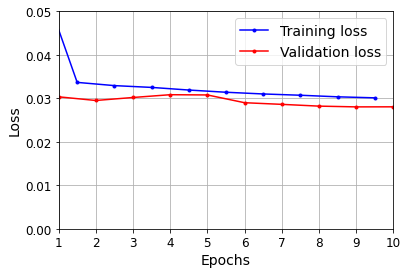

In [38]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 10, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

## 검증 데이터셋으로 신경망 모델을 평가합니다.

In [39]:
model.evaluate(X_valid, y_valid)

1095/1095 [==============================] - 6s 5ms/step - loss: 0.0280 - mean_squared_error: 0.0280 - mean_absolute_error: 0.1200


[0.02804815024137497, 0.02804815024137497, 0.12000586837530136]

## 예측 결과를 확인합니다.

입력 데이터 : [98.59 98.03 98.03 94.08 89.58 90.7  86.76 85.63 84.51 91.83 87.89 82.82
 89.58 86.76 86.2  87.32 82.82 87.32 85.63 85.63]
예측값 : 91.29
실제값 : 92.0
에러값 : 0.54
에러율 : 0.59%


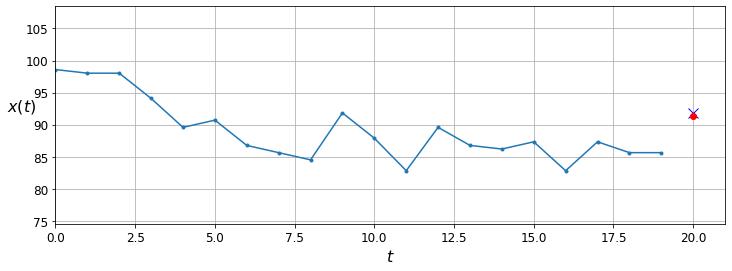

In [40]:
start = 100
fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(12, 4))
y_pred = model.predict(X_valid[start].reshape(1, 20, 1))
plot_series(X_valid[start, :, 0]*train_data_std+train_data_mean, 
            y_valid[start, 0]*train_data_std+train_data_mean, 
            y_pred[0, 0]*train_data_std+train_data_mean)

input_data = X_valid[start, :, 0]*train_data_std+train_data_mean
print("입력 데이터 : {}".format(np.round(input_data,2)))
predict_value = y_pred[0, 0]*train_data_std+train_data_mean
print("예측값 : {}".format(round(predict_value, 2)))
real_value = y_valid[start, 0]*train_data_std+train_data_mean
print("실제값 : {}".format(round(real_value)))
error = abs(predict_value-real_value)
error_rate = error/real_value*100
print("에러값 : {}".format(round(error, 2)))
print("에러율 : {}%".format(round(error_rate, 2)))

## 신경망 모델과 가중치 저장

In [41]:
m_name = os.path.splitext(file_name)[0]
model_json = model.to_json()
with open(colab_dir + '/model/' + m_name + '.json', 'w') as f : 
    f.write(model_json)
model.save_weights(colab_dir + '/model/' + m_name + '.h5')
print("Save model to disk")

Save model to disk


## 저장한 모델 불러오기

In [42]:
json_file = open(colab_dir +'/model/' + m_name + '.json', 'r')
loaded_model_json = json_file.read() 
json_file.close()
simple_lstm_model = tf.keras.models.model_from_json(loaded_model_json)
simple_lstm_model.load_weights(colab_dir +'/model/' + m_name + '.h5')
print("Load model from disk")

Load model from disk


## 저장한 모델을 사용하여 예측

입력 데이터 : [98.59 98.03 98.03 94.08 89.58 90.7  86.76 85.63 84.51 91.83 87.89 82.82
 89.58 86.76 86.2  87.32 82.82 87.32 85.63 85.63]
예측값 : 91.29
실제값 : 92.0
에러값 : 0.54
에러율 : 0.59%


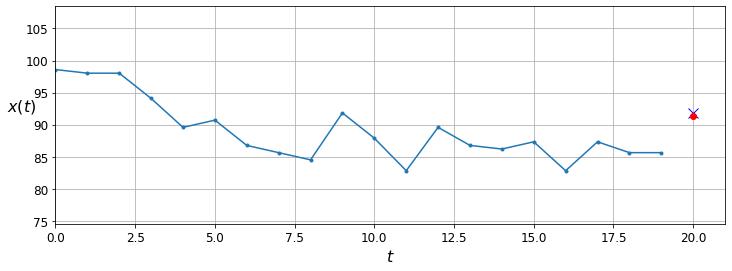

In [43]:
start = 100
fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(12, 4))
y_pred = model.predict(X_valid[start].reshape(1, 20, 1))
plot_series(X_valid[start, :, 0]*train_data_std+train_data_mean, 
            y_valid[start, 0]*train_data_std+train_data_mean, 
            y_pred[0, 0]*train_data_std+train_data_mean)

input_data = X_valid[start, :, 0]*train_data_std+train_data_mean
print("입력 데이터 : {}".format(np.round(input_data,2)))
predict_value = y_pred[0, 0]*train_data_std+train_data_mean
print("예측값 : {}".format(round(predict_value, 2)))
real_value = y_valid[start, 0]*train_data_std+train_data_mean
print("실제값 : {}".format(round(real_value)))
error = abs(predict_value-real_value)
error_rate = error/real_value*100
print("에러값 : {}".format(round(error, 2)))
print("에러율 : {}%".format(round(error_rate, 2)))